# **Prediccion de costos medicos**

In [1]:
import pandas as pd
import numpy as np # Siempre es bueno tenerlo
import matplotlib.pyplot as plt # Lo usaremos pronto
import seaborn as sns # Lo usaremos pronto

# 1. Cargar el dataset
df = pd.read_csv('insurance.csv')

# 2. Mostrar las primeras 5 filas
print("--- Vistazo a los Datos (head) ---")
print(df.head())

# 3. Mostrar la información general
print("\n--- Información del DataFrame (info) ---")
df.info()

--- Vistazo a los Datos (head) ---
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

--- Información del DataFrame (info) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [2]:
# 1. Definir el diccionario con los nuevos nombres
nuevos_nombres = {
    'age': 'edad',
    'sex': 'sexo',
    'bmi': 'imc',          # Índice de Masa Corporal
    'children': 'hijos',
    'smoker': 'fumador',
    'region': 'region',
    'charges': 'costo_seguro'  # Nuestra variable objetivo
}

# 2. Renombrar las columnas
df = df.rename(columns=nuevos_nombres)

# 3. Verificar el cambio
print("--- Columnas renombradas ---")
print(df.head())

--- Columnas renombradas ---
   edad    sexo     imc  hijos fumador     region  costo_seguro
0    19  female  27.900      0     yes  southwest   16884.92400
1    18    male  33.770      1      no  southeast    1725.55230
2    28    male  33.000      3      no  southeast    4449.46200
3    33    male  22.705      0      no  northwest   21984.47061
4    32    male  28.880      0      no  northwest    3866.85520


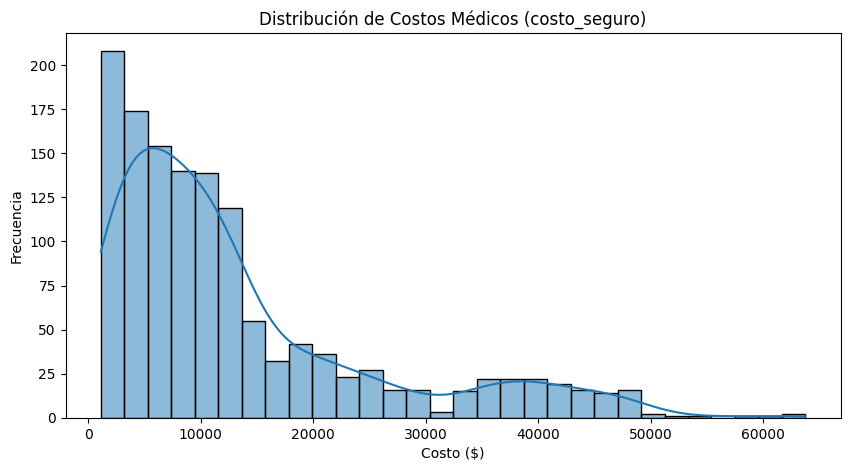

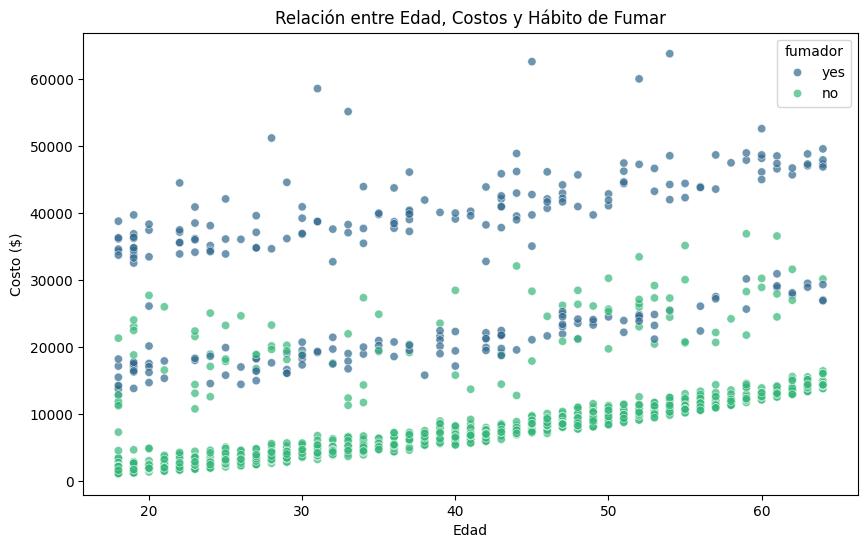

In [4]:
# 1. Ver la distribución de nuestra variable objetivo: 'costo_seguro'
plt.figure(figsize=(10, 5))
sns.histplot(df['costo_seguro'], kde=True, bins=30)
plt.title('Distribución de Costos Médicos (costo_seguro)')
plt.xlabel('Costo ($)')
plt.ylabel('Frecuencia')
plt.show()




# 2. Ver la relación entre edad, costos y si es fumador
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='edad', y='costo_seguro', hue='fumador', palette='viridis', alpha=0.7)
plt.title('Relación entre Edad, Costos y Hábito de Fumar')
plt.xlabel('Edad')
plt.ylabel('Costo ($)')
plt.show()

# **Preprocesamiento de Datos**

--- DataFrame Procesado (head) ---
   edad  sexo     imc  hijos  fumador  region_northwest  region_southeast  \
0    19     0  27.900      0        1             False             False   
1    18     1  33.770      1        0             False              True   
2    28     1  33.000      3        0             False              True   
3    33     1  22.705      0        0              True             False   
4    32     1  28.880      0        0              True             False   

   region_southwest  costo_seguro_log  
0              True          9.734236  
1             False          7.453882  
2             False          8.400763  
3             False          9.998137  
4             False          8.260455  

--- Nueva Distribución de Costos (Logarítmica) ---


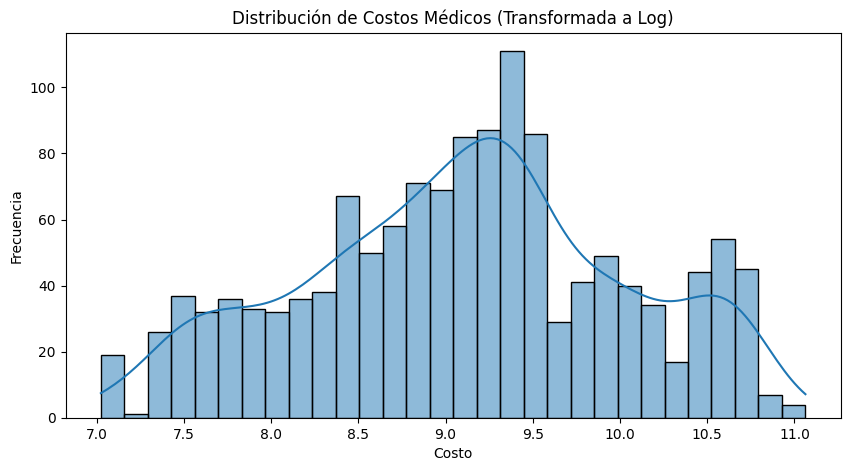

In [6]:
# 1. Copia del DataFrame para el preprocesamiento
df_procesado = df.copy()

# --- Tarea 1: Codificar Variables Categóricas ---

# 'sexo' y 'fumador' tienen solo 2 valores (binarios). Usamos .map()
df_procesado['sexo'] = df_procesado['sexo'].map({'female': 0, 'male': 1})
df_procesado['fumador'] = df_procesado['fumador'].map({'no': 0, 'yes': 1})

# 'region' tiene 4 valores. Usamos One-Hot Encoding (pd.get_dummies)
# drop_first=True evita un problema estadístico llamado "multicolinealidad"
df_procesado = pd.get_dummies(df_procesado, columns=['region'], drop_first=True)

# --- Tarea 2: Transformación Logarítmica del Objetivo ---

# Aplicamos log(x+1) a 'costo_seguro' para normalizar su distribución
# Usamos np.log1p (que es log(1+x)) por si hubiera algún costo de $0 (aunque aquí no hay)
df_procesado['costo_seguro_log'] = np.log1p(df_procesado['costo_seguro'])

# Eliminamos la columna de costo original, ya que ahora predeciremos el 'costo_seguro_log'
df_procesado = df_procesado.drop('costo_seguro', axis=1)


# --- Verificación ---
print("--- DataFrame Procesado (head) ---")
print(df_procesado.head())

# --- Verificación Gráfica ---
# Vamos a ver si arreglamos el sesgo de la variable 'costo_seguro'
print("\n--- Nueva Distribución de Costos (Logarítmica) ---")
plt.figure(figsize=(10, 5))
sns.histplot(df_procesado['costo_seguro_log'], kde=True, bins=30)
plt.title('Distribución de Costos Médicos (Transformada a Log)')
plt.xlabel('Log(Costo)')
plt.ylabel('Frecuencia')
plt.show()

# **Escalado de datos**

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Definir X (features) e y (target)
X = df_procesado.drop('costo_seguro_log', axis=1)
y = df_procesado['costo_seguro_log']

# 2. Dividir los datos (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Escalar solo las columnas numéricas
# No escalamos las columnas que son binarias (0/1) como 'sexo', 'fumador' o las regiones
cols_a_escalar = ['edad', 'imc', 'hijos']

scaler = StandardScaler()

# OJO: Ajustamos (fit) el scaler SOLO con los datos de X_train
X_train[cols_a_escalar] = scaler.fit_transform(X_train[cols_a_escalar])

# Aplicamos (transform) esa misma transformación a X_test
X_test[cols_a_escalar] = scaler.transform(X_test[cols_a_escalar])


# --- Verificación ---
print("--- X_train después del escalado (head) ---")
print(X_train.head())

print(f"\nForma de X_train: {X_train.shape}")
print(f"Forma de X_test: {X_test.shape}")

--- X_train después del escalado (head) ---
          edad  sexo       imc     hijos  fumador  region_northwest  \
560   0.472227     0 -1.756525  0.734336        0              True   
1285  0.543313     0 -1.033082 -0.911192        0             False   
1142  0.898745     0 -0.943687 -0.911192        0             False   
969  -0.025379     0  0.622393  3.202629        0             False   
486   1.040918     0 -1.504893  1.557100        0              True   

      region_southeast  region_southwest  
560              False             False  
1285             False             False  
1142              True             False  
969               True             False  
486              False             False  

Forma de X_train: (1070, 8)
Forma de X_test: (268, 8)


# **Entrenamiento de modelos**
1. regresion lineal
2. random forest

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score # Métricas de evaluación

# --- 1. Modelo de Regresión Lineal ---
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

# --- 2. Modelo de Random Forest ---
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

print("¡Modelos entrenados con éxito!")

# --- 3. Hacer predicciones en el set de prueba ---
y_pred_lin = lin_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

print("¡Predicciones generadas!")

¡Modelos entrenados con éxito!
¡Predicciones generadas!


--- Evaluación en Escala Logarítmica (Datos de Entrenamiento) ---
Regresión Lineal (R2 Log): 0.804741079139302
Random Forest (R2 Log): 0.8484801139659841

--- Evaluación en DÓLARES REALES (Datos de Prueba) ---
Regresión Lineal (R2): 0.6067
Random Forest (R2): 0.8778

Regresión Lineal (RMSE en $): 7814.06
Random Forest (RMSE en $): 4356.50


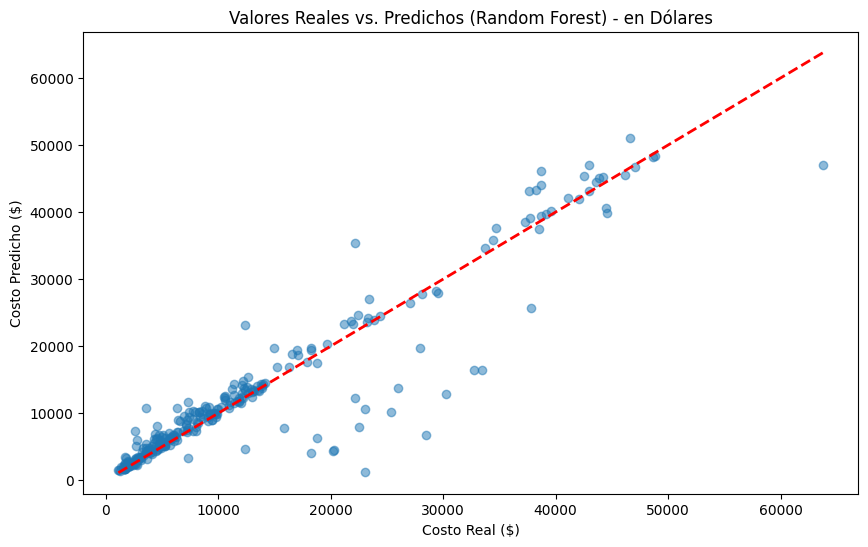

In [9]:
# --- 1. Evaluación en la escala LOGARÍTMICA (para una comparación técnica) ---
print("--- Evaluación en Escala Logarítmica (Datos de Entrenamiento) ---")
print("Regresión Lineal (R2 Log):", r2_score(y_test, y_pred_lin))
print("Random Forest (R2 Log):", r2_score(y_test, y_pred_rf))

# --- 2. Revertir la transformación a DÓLARES REALES ---
# Usamos np.expm1() porque usamos np.log1p() al inicio
y_test_orig = np.expm1(y_test)
y_pred_lin_orig = np.expm1(y_pred_lin)
y_pred_rf_orig = np.expm1(y_pred_rf)

# --- 3. Evaluación en DÓLARES REALES (¡La que nos importa!) ---
print("\n--- Evaluación en DÓLARES REALES (Datos de Prueba) ---")

# R-cuadrado (R2)
print(f"Regresión Lineal (R2): {r2_score(y_test_orig, y_pred_lin_orig):.4f}")
print(f"Random Forest (R2): {r2_score(y_test_orig, y_pred_rf_orig):.4f}")

# Error Cuadrático Medio (RMSE) - ¡Esto es en dólares!
rmse_lin = np.sqrt(mean_squared_error(y_test_orig, y_pred_lin_orig))
rmse_rf = np.sqrt(mean_squared_error(y_test_orig, y_pred_rf_orig))

print(f"\nRegresión Lineal (RMSE en $): {rmse_lin:.2f}")
print(f"Random Forest (RMSE en $): {rmse_rf:.2f}")

# --- 4. Visualización del MEJOR modelo (Random Forest) ---
# Un buen modelo tendrá los puntos alineados en la diagonal (Predicho = Real)
plt.figure(figsize=(10, 6))
plt.scatter(y_test_orig, y_pred_rf_orig, alpha=0.5)
plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--', lw=2)
plt.title('Valores Reales vs. Predichos (Random Forest) - en Dólares')
plt.xlabel('Costo Real ($)')
plt.ylabel('Costo Predicho ($)')
plt.show()

# **Que aprendio el modelo??**

--- Ranking de Importancia de Variables ---
            Feature  Importance
4           fumador    0.436858
0              edad    0.380286
2               imc    0.105801
3             hijos    0.041764
1              sexo    0.011570
6  region_southeast    0.009018
5  region_northwest    0.007670
7  region_southwest    0.007034


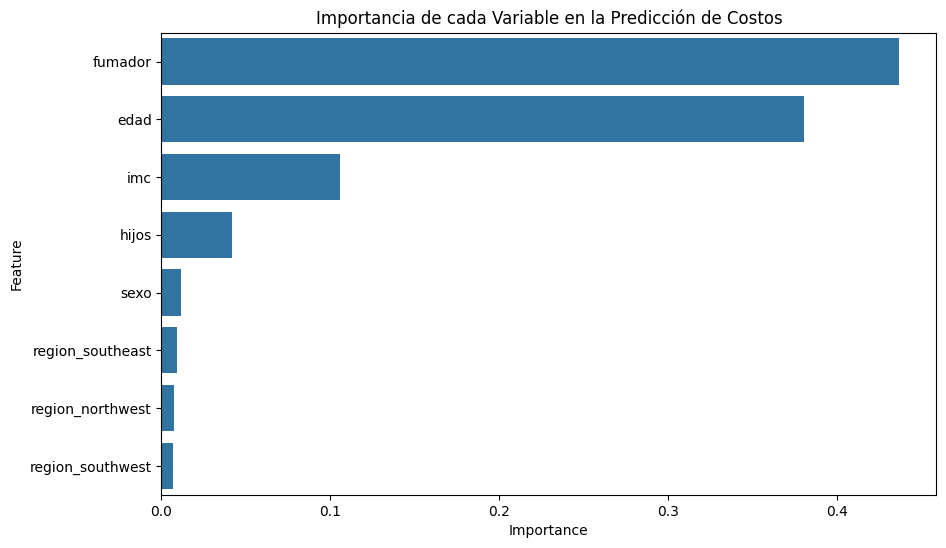

In [10]:
# 1. Obtener las importancias del modelo ganador
importances = rf_model.feature_importances_

# 2. Crear un DataFrame para verlas fácilmente
# Usamos X_train.columns para obtener los nombres de las features
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False) # Ordenar de mayor a menor

# 3. Mostrar el ranking
print("--- Ranking de Importancia de Variables ---")
print(feature_importance_df)

# 4. Graficar el ranking
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df, x='Importance', y='Feature')
plt.title('Importancia de cada Variable en la Predicción de Costos')
plt.show()

In [11]:
import joblib


# Guardar el modelo de Random Forest
joblib.dump(rf_model, 'modelo_costos_rf.joblib')

# Guardar el escalador
joblib.dump(scaler, 'scaler_costos.joblib')

print("¡Modelo y escalador de Costos guardados!")

¡Modelo y escalador de Costos guardados!
